In [1]:
import os
import mne
import numpy as np
import pandas as pd

from scipy.signal import butter, filtfilt # Keep original filtfilt for the improved func
# Removed resample as it wasn't used, can be added back if needed
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew, kurtosis
# Removed pywt as it wasn't used, can be added back if needed

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

# Suppress specific MNE warnings if desired, adjust as needed
warnings.filterwarnings("ignore", message=".*pick_types.*legacy function.*")
warnings.filterwarnings("ignore", message=".*maximum epoch persistence is not supported.*") # Common non-critical warning
mne.set_log_level('WARNING') # Reduce MNE verbosity

In [2]:
def bandpass_filter_improved(data, lowcut=12.0, highcut=35.0, fs=250, order=5):
    '''Apply a bandpass filter to the EEG data efficiently.
    Args:
        data: ndarray of shape (num_samples, num_channels, num_timesteps)
              or (num_channels, num_timesteps)
        lowcut: float, lower frequency bound
        highcut: float, upper frequency bound
        fs: int, sampling frequency
        order: int, filter order
    Returns:
        filtered_data: ndarray of the same shape as input
    '''
    nyquist = 0.5 * 250
    low = lowcut / nyquist
    high = highcut / nyquist

    # Input validation for frequencies
    low = max(0, low) # Ensure low is not negative
    high = min(1.0 - 1e-6 , high) # Ensure high is less than 1 (nyquist limit)
    
    if low >= high:
        print(f"Warning: lowcut({low}Hz) >= highcut({high}Hz). Returning original data.")
        return data

    if high >= 1.0 and low <= 0.0: # Effectively no filtering
        print("Warning: Filter range covers full spectrum. Returning original data.")
        return data
    elif low <= 0.0: # Lowpass filter
        # print("Applying Lowpass Filter")
        b, a = butter(order, high, btype='low')
    elif high >= 1.0: # Highpass filter
        # print("Applying Highpass Filter")
        b, a = butter(order, low, btype='high')
    else: # Bandpass filter
        # print("Applying Bandpass Filter")
        b, a = butter(order, [low, high], btype='band')

    # Apply the filter along the last axis (time dimension)
    try:
        filtered_data = filtfilt(b, a, data, axis=-1, padlen=min(150, data.shape[-1]-1)) # Add padlen
    except ValueError as e:
        print(f"Error during filtering: {e}. Data shape: {data.shape}. Filter params: b={b}, a={a}. Returning original data.")
        # Handle short signals that might cause issues with filtfilt's padding
        if "padlen must be less than" in str(e):
             print("Signal too short for default padding. Trying minimal padding.")
             try:
                 filtered_data = filtfilt(b, a, data, axis=-1, padlen=1)
             except Exception as e_inner:
                 print(f"Minimal padding failed: {e_inner}. Returning original data.")
                 return data
        else:
             return data

    return filtered_data

In [3]:
def normalize_eeg_channelwise(data):
    '''
    Normalize EEG data using z-score normalization per channel across time.
    Handles potential flat channels (std=0).
    Args:
        data: ndarray of shape (num_samples, num_channels, num_timesteps)
              or (num_channels, num_timesteps)
    Returns:
        data_normalized: ndarray of the same shape as input
    '''
    # Calculate mean and std along the time axis (last axis)
    mean = np.mean(data, axis=-1, keepdims=True)
    std = np.std(data, axis=-1, keepdims=True)

    # Prevent division by zero for channels with no variance
    std[std == 0] = 1e-6  # Replace 0 std with a very small number

    return (data - mean) / std

In [4]:
def segment_eeg_improved(data, segment_length):
    '''
    Segment EEG data into fixed-length non-overlapping segments efficiently.
    Args:
        data: ndarray of shape (num_samples, num_channels, num_timesteps)
        segment_length: int, length of each segment in samples
    Returns:
        segmented_data: ndarray of shape (num_total_segments, num_channels, segment_length)
                       Returns None if input data is empty or segment_length is invalid/too large.
    '''
    if data is None or data.size == 0 or segment_length <= 0:
        #print("Warning: Empty data or invalid segment length provided to segment_eeg.")
        return None

    num_samples, num_channels, num_timesteps = data.shape

    if segment_length > num_timesteps:
        #print(f"Warning: Segment length ({segment_length}) > total timesteps ({num_timesteps}). Cannot segment.")
        return None # Or return an empty array: np.empty((0, num_channels, segment_length))

    # Calculate number of full segments per sample
    num_segments_per_sample = num_timesteps // segment_length

    if num_segments_per_sample == 0:
         #print(f"Warning: No full segments possible with length {segment_length} for timesteps {num_timesteps}.")
         return np.empty((0, num_channels, segment_length))

    # Truncate data to include only full segments
    total_timesteps_used = num_segments_per_sample * segment_length
    truncated_data = data[:, :, :total_timesteps_used]

    # Reshape to separate segments
    # Shape becomes (num_samples, num_channels, num_segments_per_sample, segment_length)
    try:
        segmented_data = truncated_data.reshape(num_samples, num_channels, num_segments_per_sample, segment_length)
    except ValueError as e:
        print(f"Error reshaping data during segmentation: {e}")
        print(f"Input shape: {data.shape}, Truncated shape: {truncated_data.shape}")
        print(f"Target reshape: {(num_samples, num_channels, num_segments_per_sample, segment_length)}")
        return None


    # Transpose and reshape to desired output: (num_total_segments, num_channels, segment_length)
    # Transpose: (num_samples, num_segments_per_sample, num_channels, segment_length)
    segmented_data = segmented_data.transpose(0, 2, 1, 3)
    # Reshape: (num_samples * num_segments_per_sample, num_channels, segment_length)
    final_shape = (num_samples * num_segments_per_sample, num_channels, segment_length)
    segmented_data = segmented_data.reshape(final_shape)

    return segmented_data

In [5]:
def processing_data_corrected(X, segment_length, fs): # Added segment_length and fs params
    """ Processes a single file's data (assumed shape [1, channels, timesteps]) """
    if X is None or X.size == 0:
        return None

    # 1. Filter data
    # Use the improved, vectorized filter function
    filtered_data = bandpass_filter_improved(X, fs=fs) # Pass fs

    # 2. Normalize data
    # Use the improved, vectorized normalizer (channel-wise within the file)
    normalized_data = normalize_eeg_channelwise(filtered_data)
    # 3. Segment data
    # Use the improved, vectorized segmenter
    segmented_data = segment_eeg_improved(normalized_data, segment_length=segment_length)

    # Return ALL segments generated for this file
    return segmented_data


def mapping_data_path(input_paths, labeled_ids_set): # Use set for efficiency
    """ Filters input paths to include only those whose participant ID is in the labeled set. """
    input_paths_filtered = []
    for input_path in input_paths:
        try:
            basename = os.path.basename(input_path)
            # Assuming format like 'sub-CCXXXXXX_...' - adjust if different
            parts = basename.split('_')
            if len(parts) > 1 and parts[0].startswith('sub-'):
                 participant_id = parts[0] # e.g., 'sub-CC110033'
                 if participant_id in labeled_ids_set:
                    input_paths_filtered.append(input_path)
            else:
                 print(f"Warning: Could not parse participant ID from filename: {basename}")
        except Exception as e:
            print(f"Error parsing filename {input_path}: {e}")
    return input_paths_filtered


def load_data_corrected(data_parents_path, segment_length_seconds=4): # Parameter for segment length
    """ Loads, processes (all segments), and combines data and labels correctly. """
    print(f"Starting data loading from: {data_parents_path}")
    print(f"Using segment length: {segment_length_seconds} seconds")

    input_paths = sorted([os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(data_parents_path)) for f in fn if f.endswith('.fif')])
    label_path = os.path.join(data_parents_path, 'filtered_subjects_with_age.tsv') # Use os.path.join

    if not os.path.exists(label_path):
        print(f"Error: Label file not found at {label_path}")
        return None, None
    if not input_paths:
        print(f"Error: No .fif files found in {data_parents_path}")
        return None, None

    try:
        label_df = pd.read_csv(label_path, sep='\\t')
        # Ensure column names are correct (they might have spaces if copied/pasted)
        label_df.columns = [col.strip() for col in label_df.columns]
        print(f"Label file loaded. Columns: {label_df.columns.tolist()}")
        if 'participant_id' not in label_df.columns or 'age' not in label_df.columns:
             print("Error: Label file must contain 'participant_id' and 'age' columns.")
             return None, None

        # Create a mapping from participant_id to age for easier lookup
        label_map = label_df.set_index('participant_id')['age'].to_dict()
        labeled_ids_set = set(label_df['participant_id'].values) # Use set for faster lookup
        print(f"Found {len(labeled_ids_set)} unique participant IDs with labels.")

    except Exception as e:
        print(f"Error reading or processing label file {label_path}: {e}")
        return None, None

    input_paths_filtered = mapping_data_path(input_paths, labeled_ids_set)
    print(f"Found {len(input_paths_filtered)} files matching labeled participants.")

    if not input_paths_filtered:
        print("Error: No files found that match the participant IDs in the label file.")
        return None, None

    X_list = []
    y_list = []
    fs = None # To store sampling frequency (should be consistent)
    segment_length_samples = None # Will be set after loading first file
    n_channels = None # To store number of channels (should be consistent)

    print(f"Processing {len(input_paths_filtered)} files...")
    for i, input_path in enumerate(tqdm(input_paths_filtered, desc="Loading Files")):
        # print(f"  File {i+1}/{len(input_paths_filtered)}: {os.path.basename(input_path)}")
        try:
            raw = mne.io.read_raw_fif(input_path, preload=True) # preload=True needed for get_data

            # --- Determine fs, segment length in samples, and n_channels from first file ---
            if fs is None:
                fs = raw.info['sfreq']
                segment_length_samples = int(fs * segment_length_seconds)
                print(f"    Detected fs={fs:.2f} Hz. Using segment length={segment_length_samples} samples ({segment_length_seconds}s).")
                if segment_length_samples == 0:
                     print("Error: Calculated segment length in samples is 0. Check fs and segment_length_seconds.")
                     return None, None
            elif abs(fs - raw.info['sfreq']) > 1000 : # Check for consistency
                 print(f"    WARNING: Inconsistent sampling frequency! Expected ~{fs:.2f}, got {raw.info['sfreq']:.2f}. Skipping file: {os.path.basename(input_path)}")
                 continue

            # --- Select Channels ---
            # !!! CRITICAL: Changed misc=True to eeg=True !!!
            # Adjust if your channels are truly 'misc', but usually EEG channels are 'eeg'
            # Exclude 'bads' and common non-EEG channels like EOG, ECG if present
            try:
                 picks = mne.pick_types(raw.info, misc=True, meg=False, stim=False, eog=False, ecg=False, exclude='bads')
                 if len(picks) == 0:
                      # Fallback or alternative? Maybe check 'misc' if 'eeg' fails?
                      print(f"    WARNING: No 'eeg' channels found in {os.path.basename(input_path)}. Trying 'misc'.")
                      picks = mne.pick_types(raw.info, misc=True, exclude='bads')
                      if len(picks) == 0:
                           print(f"    WARNING: No 'eeg' or 'misc' channels found. Skipping file.")
                           continue

                 channels_to_process = raw.copy().pick(picks=picks)
                 current_n_channels = len(channels_to_process.ch_names)
                 #print(f"    Selected {current_n_channels} channels.")

            except Exception as pick_error:
                 print(f"    Error picking channels for {os.path.basename(input_path)}: {pick_error}. Skipping file.")
                 continue


            if n_channels is None:
                n_channels = current_n_channels
                print(f"    Setting expected number of channels to {n_channels}.")
            elif n_channels != current_n_channels:
                 print(f"    WARNING: Inconsistent number of channels! Expected {n_channels}, got {current_n_channels}. Skipping file: {os.path.basename(input_path)}")
                 continue


            # --- Get Data ---
            data = channels_to_process.get_data() # Shape: (num_channels, num_timesteps)
            if data.shape[1] < segment_length_samples:
                 print(f"    WARNING: File duration ({data.shape[1]/fs:.2f}s) is shorter than segment length ({segment_length_seconds}s). Skipping file: {os.path.basename(input_path)}")
                 continue

            # Add a sample dimension for processing functions expecting (samples, channels, time)
            data_batch = np.array([data]) # Shape: (1, num_channels, num_timesteps)

            # --- Process data - this now returns ALL segments for this file ---
            # Shape: (num_segments_in_file, num_channels, segment_length_samples)
            data_processed_segments = processing_data_corrected(data_batch, segment_length=segment_length_samples, fs=10)


            # --- Accumulate Data and Labels ---
            if data_processed_segments is not None and data_processed_segments.shape[0] > 0:
                num_segments_in_file = data_processed_segments.shape[0]
                # print(f"    Generated {num_segments_in_file} segments.")

                # Get the participant ID from filename to find the label
                basename = os.path.basename(input_path)
                participant_id = basename.split('_')[0] # Assumes 'sub-XXXXXX_...' format

                if participant_id in label_map:
                    age_label = label_map[participant_id]
                    X_list.append(data_processed_segments)
                    # Repeat the label for each segment generated from this file
                    y_list.extend([age_label] * num_segments_in_file)
                else:
                    print(f"    WARNING: Could not find label for participant {participant_id}. Skipping segments from this file.")
            # else:
            #     print(f"    WARNING: No segments generated after processing for {os.path.basename(input_path)}.")

        except FileNotFoundError:
            print(f"    ERROR: File not found {input_path}")
        except Exception as e:
            print(f"    ERROR processing file {os.path.basename(input_path)}: {e}")
            # Consider adding more specific error handling if needed

    # --- Final Assembly ---
    if not X_list:
        print("Error: No data segments were successfully processed and collected.")
        # Determine expected shape even if empty
        final_n_channels = n_channels if n_channels is not None else 0
        final_seg_len = segment_length_samples if segment_length_samples is not None else 0
        return np.empty((0, final_n_channels, final_seg_len)), np.empty((0,))

    # Concatenate all segments from all files
    try:
        X = np.concatenate(X_list, axis=0)
        y = np.array(y_list)
    except ValueError as e:
         print(f"Error concatenating data segments: {e}")
         # Print shapes of lists items for debugging
         #for idx, item in enumerate(X_list):
         #    print(f" Shape of X_list[{idx}]: {item.shape}")
         return None, None # Indicate failure


    print(f"Finished loading. Final shapes: X={X.shape}, y={y.shape}")

    # --- Sanity Check ---
    if X.shape[0] != y.shape[0]:
         print(f"CRITICAL WARNING: Mismatch between number of segments ({X.shape[0]}) and number of labels ({y.shape[0]})!")

    return X, y

In [6]:
# Define the path and desired segment length
data_path = '/kaggle/input/eeg-brain/Neural-Science/data'
# <<< CHOOSE YOUR SEGMENT LENGTH HERE >>>
segment_duration_seconds = 2.5 # Example: Use 5-second segments

X, y = load_data_corrected(data_path, segment_length_seconds=segment_duration_seconds)

# Check if loading was successful before proceeding
if X is None or y is None or X.size == 0 or y.size == 0:
    print("\\n--- Data Loading Failed. Stopping Execution. ---")
    # You might want to raise an error or handle this appropriately
    # For now, just stop the notebook cell execution if in an interactive environment
    assert False, "Data loading failed, cannot continue."
else:
    print("\\n--- Data Loading Successful ---")
    print(f"Loaded X shape: {X.shape}") # Should be (total_segments, num_channels, segment_len_samples)
    print(f"Loaded y shape: {y.shape}") # Should be (total_segments,)

/tmp/ipykernel_137/3751606109.py:56: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  label_df = pd.read_csv(label_path, sep='\\t')


Starting data loading from: /kaggle/input/eeg-brain/Neural-Science/data
Using segment length: 2.5 seconds
Label file loaded. Columns: ['participant_id', 'age']
Found 160 unique participant IDs with labels.
Found 214 files matching labeled participants.
Processing 214 files...


Loading Files:   0%|          | 0/214 [00:00<?, ?it/s]

    Detected fs=250.00 Hz. Using segment length=625 samples (2.5s).
    Setting expected number of channels to 52.


Loading Files: 100%|██████████| 214/214 [02:11<00:00,  1.62it/s]


Finished loading. Final shapes: X=(48714, 52, 625), y=(48714,)
\n--- Data Loading Successful ---
Loaded X shape: (48714, 52, 625)
Loaded y shape: (48714,)


In [7]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import numpy as np
# Assume you have functions to extract features like PSD
# def extract_psd_features(segment_channel_data, fs=250, bands=None):
#     # ... returns a 1D array of band powers for that single channel's segment data
#     # e.g., [delta_power, theta_power, alpha_power, beta_power, gamma_power]
#     if bands is None:
#         bands = {'delta': [0.5, 4], 'theta': [4, 8], 'alpha': [8, 13], 'beta': [13, 30], 'gamma': [30, 50]}
#     # Placeholder: Replace with actual PSD calculation (e.g., using Welch)
#     # For simplicity, let's say it returns 5 features
#     return np.random.rand(len(bands))


# Assume X_train_tensor, y_train_tensor are your PyTorch tensors
# X_train_tensor shape: (num_segments, num_channels, segment_length)
# y_train_tensor shape: (num_segments, 1) or (num_segments,)

# Convert to NumPy for scikit-learn
X_train_np = X
y_train_np = y.ravel() # Ensure y is 1D

num_segments, num_channels, segment_length = X_train_np.shape
#num_psd_bands = 5 # Example

# 1. & 2. Extract features and flatten
X_train_for_lasso = []
for i in range(num_segments):
    segment_features_flat = []
    for j in range(num_channels):
        channel_segment_data = X_train_np[i, j, :]
        # channel_psd = extract_psd_features(channel_segment_data, fs=YOUR_SAMPLING_RATE)
        # For demonstration, let's use mean and std as features per channel for simplicity
        channel_mean = np.mean(channel_segment_data)
        channel_std = np.std(channel_segment_data)
        segment_features_flat.extend([channel_mean, channel_std]) # 3 features per channel
    X_train_for_lasso.append(segment_features_flat)

X_train_for_lasso = np.array(X_train_for_lasso)
# Shape: (num_segments, num_channels * 2) in this simplified example

# Scale features for Lasso
scaler = StandardScaler()
X_train_scaled_for_lasso = scaler.fit_transform(X_train_for_lasso)

# 3. Apply Lasso
# Alpha is the regularization strength. You'll need to tune this (e.g., via cross-validation)
# Higher alpha = more sparsity (more zero coefficients)

In [8]:
'''from sklearn.linear_model import LassoCV
# ... (prepare X_train_scaled_for_lasso, y_train_np) ...
lasso_cv = LassoCV(cv=10, random_state=0, max_iter=5000) # cv=5 for 5-fold CV
lasso_cv.fit(X_train_scaled_for_lasso, y_train_np)
print(f"Optimal alpha found by LassoCV: {lasso_cv.alpha_}")
# Use lasso_cv.coef_ for channel importance
lasso_coefs = lasso_cv.coef_
# Calculate importance per channel (example: sum of absolute coefficients)
num_features_per_channel = 2 # In our simplified example (mean, std)
channel_importance = []
for j in range(num_channels):
    start_idx = j * num_features_per_channel
    end_idx = start_idx + num_features_per_channel
    channel_coefs = lasso_coefs[start_idx:end_idx]
    importance = np.sum(np.abs(channel_coefs))
    channel_importance.append(importance)

# Select top N channels
channel_indices_sorted_by_importance = np.argsort(channel_importance)[::-1] # Descending'''

'from sklearn.linear_model import LassoCV\n# ... (prepare X_train_scaled_for_lasso, y_train_np) ...\nlasso_cv = LassoCV(cv=10, random_state=0, max_iter=5000) # cv=5 for 5-fold CV\nlasso_cv.fit(X_train_scaled_for_lasso, y_train_np)\nprint(f"Optimal alpha found by LassoCV: {lasso_cv.alpha_}")\n# Use lasso_cv.coef_ for channel importance\nlasso_coefs = lasso_cv.coef_\n# Calculate importance per channel (example: sum of absolute coefficients)\nnum_features_per_channel = 2 # In our simplified example (mean, std)\nchannel_importance = []\nfor j in range(num_channels):\n    start_idx = j * num_features_per_channel\n    end_idx = start_idx + num_features_per_channel\n    channel_coefs = lasso_coefs[start_idx:end_idx]\n    importance = np.sum(np.abs(channel_coefs))\n    channel_importance.append(importance)\n\n# Select top N channels\nchannel_indices_sorted_by_importance = np.argsort(channel_importance)[::-1] # Descending'

In [9]:
'''channel_importance_np = np.array(channel_importance)

# --- MODIFIED CHANNEL SELECTION ---
# Select channels where the calculated importance is greater than zero
selected_channel_indices = np.where(channel_importance_np > 0)[0]
selected_channel_indices'''

'channel_importance_np = np.array(channel_importance)\n\n# --- MODIFIED CHANNEL SELECTION ---\n# Select channels where the calculated importance is greater than zero\nselected_channel_indices = np.where(channel_importance_np > 0)[0]\nselected_channel_indices'

In [10]:
#NUM_CHANNELS_TO_SELECT = 20 # Example
#selected_channel_indices = channel_indices_sorted_by_importance[:NUM_CHANNELS_TO_SELECT]
selected_channel_indices = [ 0, 1, 2, 8, 13, 20, 22, 27, 33, 34, 35, 44]
print(f"Selected channel indices: {selected_channel_indices}")
X_selected_channels = X[:, selected_channel_indices, :]
del X

Selected channel indices: [0, 1, 2, 8, 13, 20, 22, 27, 33, 34, 35, 44]


[ 0  1  2  8 13 20 22 27 33 34 35 44]

In [11]:
selected_channel_indices

[0, 1, 2, 8, 13, 20, 22, 27, 33, 34, 35, 44]

In [12]:
# Ensure data is valid before converting
if X_selected_channels is not None and y is not None and X_selected_channels.size > 0 and y.size > 0:
    X_tensor = torch.tensor(X_selected_channels, dtype=torch.float32) # Use float32 for PyTorch
    y_tensor = torch.tensor(y, dtype=torch.float32) # Use float32 for regression

    # Reshape y to match PyTorch requirements for loss function (batch_size, 1)
    y_tensor = y_tensor.view(-1, 1)

    print(f"\\n--- Tensors Created ---")
    print(f"X_tensor shape: {X_tensor.shape}")
    print(f"y_tensor shape: {y_tensor.shape}")
else:
    print("\\n--- Skipping Tensor Conversion due to Loading Errors ---")
    X_tensor, y_tensor = None, None # Ensure they are None if loading failed
del X_selected_channels
del y

\n--- Tensors Created ---
X_tensor shape: torch.Size([48714, 12, 625])
y_tensor shape: torch.Size([48714, 1])


In [13]:
# Check if tensors are valid before splitting
if X_tensor is not None and y_tensor is not None:
    # !!! IMPORTANT NOTE ON SPLITTING !!!
    # This basic train_test_split shuffles segments randomly.
    # Segments from the SAME SUBJECT might end up in BOTH train and test sets.
    # This leads to data leakage and overly optimistic results.
    # A better approach is SUBJECT-AWARE splitting: Split participant IDs first,
    # then collect all segments belonging to train/test subjects.
    # For now, we proceed with the simple split as in the original code.

    test_fraction = 0.3 # Use a fraction for robustness if total segments vary
    test_size_count = int(len(X_tensor) * test_fraction)
    # Ensure test_size is at least 1 if dataset is very small, adjust if needed
    test_size_count = max(1, test_size_count) if len(X_tensor) > 0 else 0

    if test_size_count > 0 and test_size_count < len(X_tensor):
        X_train, X_test, y_train, y_test = train_test_split(
            X_tensor, y_tensor, test_size=test_size_count, random_state=42, shuffle=True
        )

        # Create DataLoader for batch processing
        train_dataset = TensorDataset(X_train, y_train)
        test_dataset = TensorDataset(X_test, y_test)

        batch_size = 16 # Adjusted batch size, tune as needed
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True) # drop_last can help with stability
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        print("\\n--- DataLoaders Created ---")
        print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")
        print(f"Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")
    else:
        print("\\n--- Not enough data to perform train/test split ---")
        train_loader, test_loader = None, None
else:
    print("\\n--- Skipping Train/Test Split due to Loading Errors ---")
    train_loader, test_loader = None, None
#del X_tensor
#del y_tensor

\n--- DataLoaders Created ---
Train samples: 34100, Test samples: 14614
Train batches: 2131, Test batches: 914


In [14]:
mean_age_train = torch.mean(y_train)
baseline_predictions = torch.full_like(y_test, mean_age_train) # y_val_numpy are true ages in validation
baseline_mae = torch.mean(abs(y_test - baseline_predictions))
print(f"Baseline MAE (predicting mean age): {baseline_mae}")

Baseline MAE (predicting mean age): 15.292816162109375


In [ ]:
class AttentionLSTMModel(nn.Module):
    def __init__(self, num_channels, embedding_dim=128, lstm_hidden=64, nhead=1, dim_ff=256, dropout=0.3):
        super(AttentionLSTMModel, self).__init__()

        self.embedding_dim = embedding_dim
        self.input_proj = nn.Linear(num_channels, self.embedding_dim) # Project channels to embedding dim
        self.pos_encoder = nn.Identity() # Placeholder: Consider adding positional encoding for transformer

        # Attention Block (Transformer Encoder Layer)
        # Ensure embedding_dim is divisible by nhead
        if embedding_dim % nhead != 0:
            # Find nearest valid nhead
            valid_nheads = [h for h in range(1, embedding_dim + 1) if embedding_dim % h == 0]
            nhead = valid_nheads[-1] if valid_nheads else 1 # Default to 1 if no divisors found
            print(f"Warning: embedding_dim ({embedding_dim}) not divisible by nhead (8). Adjusted nhead to {nhead}.")

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.embedding_dim,
            nhead=nhead,
            dim_feedforward=dim_ff,
            dropout=dropout, # Apply dropout within transformer
            batch_first=True,
            activation='relu' # Common activation
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2) # Single layer transformer

        # LSTM Layers - Using nn.LSTM is generally preferred over nn.RNN
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=lstm_hidden, num_layers=1, bidirectional = True,batch_first=True, dropout=dropout if 1 > 1 else 0) # Dropout applies between layers if num_layers > 1
        # A second LSTM layer might be too much, consider removing or reducing hidden size
        # self.lstm2 = nn.LSTM(input_size=lstm_hidden, hidden_size=lstm_hidden // 2, num_layers=1, batch_first=True, dropout=dropout if 1 > 1 else 0)

        # Regression Head
        self.fc = nn.Sequential(
            nn.LayerNorm(lstm_hidden * 2), # Add LayerNorm before activation
            nn.ReLU(),
            nn.Dropout(dropout), # Use consistent dropout rate
            nn.Linear(lstm_hidden * 2, lstm_hidden // 2), # Add another layer
            nn.LayerNorm(lstm_hidden // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(lstm_hidden // 2, 1) # Final output
        )

    def forward(self, x):
        # x shape: (batch_size, channels, timesteps)
        # print("Input:", x.shape)
        x = x.permute(0, 2, 1)  # → (batch_size, timesteps, channels)
        # print("Permuted:", x.shape)
        x = self.input_proj(x)  # → (batch_size, timesteps, embedding_dim)
        # print("Projected:", x.shape)

        # Add positional encoding if using it
        x = self.pos_encoder(x)

        # Apply Transformer Encoder
        x = self.transformer_encoder(x) # → (batch_size, timesteps, embedding_dim)
        # print("After Transformer:", x.shape)

        # Apply LSTM
        # LSTM output: output_seq, (h_n, c_n)
        # output_seq shape: (batch_size, timesteps, hidden_size)
        # h_n shape: (num_layers, batch_size, hidden_size)
        lstm_out, (h_n, _) = self.lstm(x)
        #print("After LSTM1 output:", lstm_out.shape)
        #print("After LSTM1 hidden:", h_n.shape)

        # Optional second LSTM
        # lstm_out, (h_n, _) = self.lstm2(lstm_out)
        # print("After LSTM2 output:", lstm_out.shape)
        # print("After LSTM2 hidden:", h_n.shape)


        # Get the output of the last time step from the last LSTM layer
        # h_n is shape (num_layers, batch_size, hidden_size), we want the last layer's hidden state
        #last_hidden_state = h_n[-1, :, :] # → (batch_size, hidden_size)
        # Concatenate them along the feature dimension
        last_hidden_state_forward = h_n[0, :, :]  # Shape: (batch_size, hidden_size)
        last_hidden_state_backward = h_n[1, :, :] # Shape: (batch_size, hidden_size)

        # Concatenate:
        last_hidden_state = torch.cat((last_hidden_state_forward, last_hidden_state_backward), dim=1)
        #print("Last Hidden State:", last_hidden_state.shape)

        # Alternatively, use the last time step of the output sequence:
        # last_time_step_output = lstm_out[:, -1, :] # -> (batch_size, hidden_size)

        x = self.fc(last_hidden_state) # Feed the final hidden state to the classifier
        # print("Final Output:", x.shape)
        return x

In [16]:
from transformers import get_cosine_schedule_with_warmup, get_polynomial_decay_schedule_with_warmup
# Ensure data loaders are valid before initializing model
if train_loader is not None:
    # Get input shape from the loaded data
    # X_tensor shape: (total_segments, num_channels, segment_len_samples)
    input_channels = 12
    #X_tensor.shape[1] # Timesteps not directly needed by this model init

    # --- Hyperparameters ---
    EMBEDDING_DIM = 128 # Dimension after initial projection
    LSTM_HIDDEN = 128   # LSTM hidden units
    NHEAD = 2         # Transformer heads (must divide EMBEDDING_DIM)
    DIM_FF = 512       # Transformer feedforward dim
    DROPOUT = 0.15      # Dropout rate
    LEARNING_RATE = 1e-4 # Learning rate
    WEIGHT_DECAY = 1e-5  # Weight decay for regularization

    model = AttentionLSTMModel(
        num_channels=input_channels,
        embedding_dim=EMBEDDING_DIM,
        lstm_hidden=LSTM_HIDDEN,
        nhead=NHEAD,
        dim_ff=DIM_FF,
        dropout=DROPOUT
    )

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(f"Using device: {device}")

    criterion = nn.L1Loss() # MAE Loss for age regression
    #criterion = nn.MSELoss() # Option: Mean Squared Error

    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY) # AdamW is often preferred
    num_training_steps = 100 * len(train_loader)
    num_warmup_steps = 100
    #int(0.01 * num_training_steps)  # 10% warmup

    '''scheduler = get_polynomial_decay_schedule_with_warmup(
                optimizer, 
                num_warmup_steps=num_warmup_steps,
                num_training_steps=num_training_steps
    )'''
    '''get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
    )'''
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, verbose=True, min_lr=1e-6) # More patience, lower factor

    # Print model summary
    print("\\n--- Model Initialized ---")
    print(model)
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total Trainable Parameters: {total_params:,}")

else:
    print("\\n--- Skipping Model Initialization due to Loading/Splitting Errors ---")
    model = None
    criterion = None
    optimizer = None
    scheduler = None
    device = "cpu" # Default to CPU if no model/GPU

Using device: cuda
\n--- Model Initialized ---
AttentionLSTMModel(
  (input_proj): Linear(in_features=12, out_features=128, bias=True)
  (pos_encoder): Identity()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.15, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.15, inplace=False)
        (dropout2): Dropout(p=0.15, inplace=False)
      )
    )
  )
  (lstm): LSTM(128, 128, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): LayerNorm((256,), eps=1e-

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [17]:
class EarlyStopping:
    def __init__(self, path_to_save, patience=10, delta=0.001, restore_best_weights=True, verbose=True):
        """
        Args:
            path_to_save (str): Path to save the best model state.
            patience (int): How many epochs to wait after last time validation loss improved.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            restore_best_weights (bool): Whether to restore model weights from the epoch with the best value of the monitored quantity.
            verbose (bool): If True, prints a message for each validation loss improvement.
        """
        self.patience = patience
        self.delta = delta
        self.restore_best_weights = restore_best_weights
        self.path_to_save = path_to_save
        self.verbose = verbose

        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_val_loss = np.Inf
        self.best_epoch = 0
        self.best_weights = None


    def __call__(self, val_loss, epoch, model):
        score = -val_loss # We want to maximize the negative loss (minimize loss)

        if self.best_score is None:
            self.best_score = score
            self.best_val_loss = val_loss
            self.best_epoch = epoch
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                 print(f'EarlyStopping counter: {self.counter} out of {self.patience} (Best val_loss: {self.best_val_loss:.4f} at epoch {self.best_epoch})')
            if self.counter >= self.patience:
                self.early_stop = True
                print(f"Early stopping triggered after {epoch} epochs.")
        else:
            # Improvement detected
            self.best_score = score
            self.best_val_loss = val_loss
            self.best_epoch = epoch
            self.save_checkpoint(val_loss, model)
            self.counter = 0 # Reset counter

        return self.early_stop

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.best_val_loss:.4f} --> {val_loss:.4f}). Saving model to {self.path_to_save} ...')
        # Save the current best weights
        self.best_weights = model.state_dict()
        torch.save(self.best_weights, self.path_to_save)
        # Update the stored best loss (needed if comparing score < best_score + delta)
        # self.best_val_loss = val_loss # Already updated before calling save_checkpoint

    def load_best_weights(self, model):
         if self.restore_best_weights and self.best_weights is not None:
             print(f"Restoring model weights from epoch {self.best_epoch} with val_loss: {self.best_val_loss:.4f}")
             model.load_state_dict(self.best_weights)
         elif self.restore_best_weights:
              print("Warning: restore_best_weights=True but no best weights were saved.")

In [18]:
def train_and_eval_model(model, train_loader, test_loader, criterion, optimizer, device, epochs=100, scheduler=None, early_stopping=None):

    if model is None or train_loader is None or test_loader is None:
        print("Model or DataLoaders not initialized. Skipping training.")
        return [], []

    train_losses = []
    test_losses = []

    print("\\n--- Starting Training ---")
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        # Use tqdm for progress bar
        train_pbar = tqdm(train_loader, unit='batch', desc=f'Train Epoch {epoch + 1}/{epochs}')
        for X_batch, y_batch in train_pbar:
            # Move data to the correct device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            ypred = model(X_batch)
            loss = criterion(ypred, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            # Optional: Gradient Clipping
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_train_loss += loss.item() * X_batch.size(0) # Weighted average contribution
            train_pbar.set_postfix(loss=loss.item()) # Show loss in progress bar


        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        print(f'---> Epoch {epoch + 1} Train Loss: {epoch_train_loss:.4f}')

        # Validation phase
        model.eval()
        running_test_loss = 0.0
        test_pbar = tqdm(test_loader, unit='batch', desc=f'Eval Epoch {epoch + 1}/{epochs}', leave=False)
        with torch.no_grad(): # Use no_grad for evaluation efficiency
            for X_batch, y_batch in test_pbar:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                ypred = model(X_batch)
                loss = criterion(ypred, y_batch)
                running_test_loss += loss.item() * X_batch.size(0)
                test_pbar.set_postfix(loss=loss.item())

        epoch_test_loss = running_test_loss / len(test_loader.dataset)
        test_losses.append(epoch_test_loss)
        print(f'---> Epoch {epoch + 1} Test Loss:  {epoch_test_loss:.4f}')

        # Learning rate scheduling step
        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(epoch_test_loss) # Pass validation loss
                # Print current LR (optional)
                # current_lr = optimizer.param_groups[0]['lr']
                # print(f"    Current LR: {current_lr:.6f}")
            else:
                 scheduler.step() # For other schedulers like StepLR

        # Early stopping check
        if early_stopping:
            if early_stopping(epoch_test_loss, epoch + 1, model): # Pass epoch number (1-based)
                break # Stop training loop

        print("-" * 50) # Separator between epochs

    print("--- Training Finished ---")

    # Load best weights if early stopping was used and configured to restore
    if early_stopping:
        early_stopping.load_best_weights(model)


    return train_losses, test_losses

In [19]:
# Ensure model and dataloaders are ready
if model and train_loader and test_loader and criterion and optimizer and device:
    # Initialize Early Stopping
    early_stopper = EarlyStopping(path_to_save='best_model_cnnlstm_corrected.pth', patience=50, delta=0.01, verbose=True) # Increased patience

    # --- Start Training ---
    num_epochs = 10 # Adjust as needed
    train_losses, test_losses = train_and_eval_model(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device, # Pass the device
        epochs=num_epochs,
        scheduler=scheduler,
        early_stopping=early_stopper
    )

    print("\\n--- Post-Training Evaluation ---")
    print(f"Minimum Training Loss: {np.min(train_losses):.4f}")
    print(f"Minimum Validation Loss: {np.min(test_losses):.4f}")
    if early_stopper.early_stop:
         print(f"Stopped early at epoch {early_stopper.best_epoch}. Best Validation Loss: {early_stopper.best_val_loss:.4f}")

else:
    print("\\n--- Cannot Start Training due to Initialization Errors ---")
    train_losses, test_losses = [], [] # Assign empty lists

\n--- Starting Training ---


Train Epoch 1/10: 100%|██████████| 2131/2131 [03:02<00:00, 11.65batch/s, loss=36.2]


---> Epoch 1 Train Loss: 42.6945


---> Epoch 1 Test Loss:  36.0148
Validation loss decreased (36.0148 --> 36.0148). Saving model to best_model_cnnlstm_corrected.pth ...
--------------------------------------------------


Train Epoch 2/10: 100%|██████████| 2131/2131 [03:02<00:00, 11.70batch/s, loss=24.6]


---> Epoch 2 Train Loss: 28.4062


---> Epoch 2 Test Loss:  21.7879
Validation loss decreased (21.7879 --> 21.7879). Saving model to best_model_cnnlstm_corrected.pth ...
--------------------------------------------------


Train Epoch 3/10: 100%|██████████| 2131/2131 [03:02<00:00, 11.70batch/s, loss=14.8]


---> Epoch 3 Train Loss: 18.0983


---> Epoch 3 Test Loss:  15.6682
Validation loss decreased (15.6682 --> 15.6682). Saving model to best_model_cnnlstm_corrected.pth ...
--------------------------------------------------


Train Epoch 4/10: 100%|██████████| 2131/2131 [03:02<00:00, 11.70batch/s, loss=15.9]


---> Epoch 4 Train Loss: 15.5991


---> Epoch 4 Test Loss:  15.2722
Validation loss decreased (15.2722 --> 15.2722). Saving model to best_model_cnnlstm_corrected.pth ...
--------------------------------------------------


Train Epoch 5/10: 100%|██████████| 2131/2131 [03:02<00:00, 11.70batch/s, loss=12.1]


---> Epoch 5 Train Loss: 15.4999


---> Epoch 5 Test Loss:  15.2825
EarlyStopping counter: 1 out of 50 (Best val_loss: 15.2722 at epoch 4)
--------------------------------------------------


Train Epoch 6/10: 100%|██████████| 2131/2131 [03:02<00:00, 11.70batch/s, loss=17.5]


---> Epoch 6 Train Loss: 15.4759


---> Epoch 6 Test Loss:  15.2734
EarlyStopping counter: 2 out of 50 (Best val_loss: 15.2722 at epoch 4)
--------------------------------------------------


Train Epoch 7/10: 100%|██████████| 2131/2131 [03:02<00:00, 11.70batch/s, loss=15.2]


---> Epoch 7 Train Loss: 15.4831


---> Epoch 7 Test Loss:  15.2780
EarlyStopping counter: 3 out of 50 (Best val_loss: 15.2722 at epoch 4)
--------------------------------------------------


Train Epoch 8/10: 100%|██████████| 2131/2131 [03:02<00:00, 11.69batch/s, loss=13.9]


---> Epoch 8 Train Loss: 15.4915


---> Epoch 8 Test Loss:  15.2797
EarlyStopping counter: 4 out of 50 (Best val_loss: 15.2722 at epoch 4)
--------------------------------------------------


Train Epoch 9/10: 100%|██████████| 2131/2131 [03:02<00:00, 11.69batch/s, loss=14.8]


---> Epoch 9 Train Loss: 15.5460


---> Epoch 9 Test Loss:  15.2781
EarlyStopping counter: 5 out of 50 (Best val_loss: 15.2722 at epoch 4)
--------------------------------------------------


Train Epoch 10/10: 100%|██████████| 2131/2131 [03:02<00:00, 11.69batch/s, loss=9.12]


---> Epoch 10 Train Loss: 15.4659


---> Epoch 10 Test Loss:  15.2772
EarlyStopping counter: 6 out of 50 (Best val_loss: 15.2722 at epoch 4)
--------------------------------------------------
--- Training Finished ---
Restoring model weights from epoch 4 with val_loss: 15.2722
\n--- Post-Training Evaluation ---
Minimum Training Loss: 15.4659
Minimum Validation Loss: 15.2722


In [20]:
import gc
gc.collect()
torch.cuda.empty_cache()
del model

In [21]:
# if train_losses and test_losses:
#     print(f"Final Minimum Training Loss: {np.min(train_losses):.4f}")
#     print(f"Final Minimum Validation Loss: {np.min(test_losses):.4f}")
# else:
#      print("No training results available.")

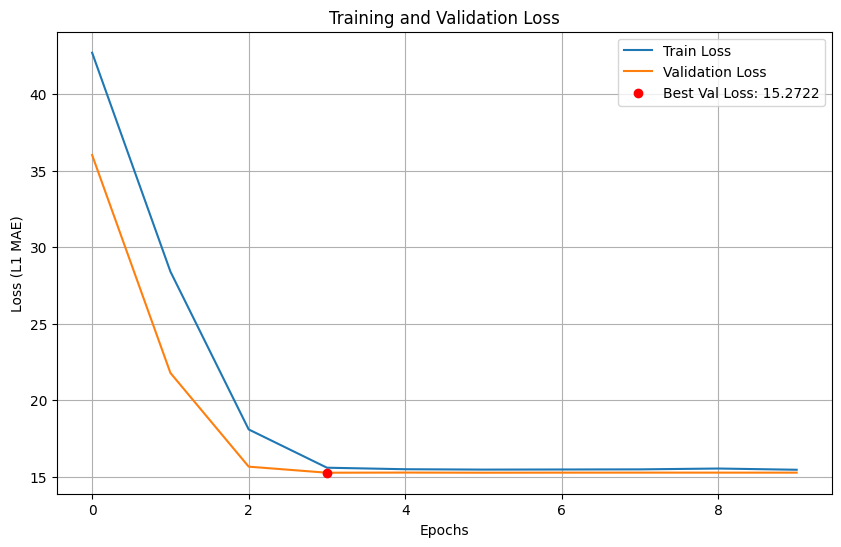

In [22]:
if train_losses and test_losses:
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Validation Loss')

    # Find the epoch with the minimum validation loss
    min_val_loss_epoch = np.argmin(test_losses)
    min_val_loss = np.min(test_losses)
    plt.scatter(min_val_loss_epoch, min_val_loss, color='red', zorder=5, label=f'Best Val Loss: {min_val_loss:.4f}')

    # If early stopping happened, mark where it stopped conceptually (best epoch)
    if 'early_stopper' in globals() and early_stopper.early_stop:
         plt.axvline(early_stopper.best_epoch -1 , color='r', linestyle='--', label=f'Best Epoch: {early_stopper.best_epoch}') # epoch is 1-based

    plt.xlabel('Epochs')
    plt.ylabel('Loss (L1 MAE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No training data to plot.")

In [23]:
np.save("X_train_corrected.npy", X_train.cpu().numpy() if 'X_train' in globals() else None)

In [24]:
import mne
# Define the path to the file
file_path = "/kaggle/input/eeg-brain/Neural-Science/data/group_1/sub-CC110033_sflip_parc-raw.fif"
# Load the raw data
raw = mne.io.read_raw_fif(file_path, preload=True)
# Display information about the raw object
print(raw.info)

<Info | 11 non-empty values
 bads: []
 ch_names: parcel_0, parcel_1, parcel_2, parcel_3, parcel_4, parcel_5, ...
 chs: 52 misc, 17 Stimulus
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition OSL ...
 dig: 0 items
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 1916-01-09 10:21:05 UTC
 meas_id: 4 items (dict)
 nchan: 69
 projs: []
 sfreq: 250.0 Hz
>


In [25]:
# Extract only MISC channels
misc_channels = raw.copy().pick_types(misc=True)
# Display information about the extracted channels
print(misc_channels.info)

<Info | 11 non-empty values
 bads: []
 ch_names: parcel_0, parcel_1, parcel_2, parcel_3, parcel_4, parcel_5, ...
 chs: 52 misc
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition OSL ...
 dig: 0 items
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 1916-01-09 10:21:05 UTC
 meas_id: 4 items (dict)
 nchan: 52
 projs: []
 sfreq: 250.0 Hz
>


In [26]:
# Get the total recording time in seconds
total_duration = raw.times[-1]
# Alternatively, using the raw.info dictionary
total_duration_alt = raw.n_times / raw.info['sfreq']
# Print the total duration
print(f"Total recording time: {total_duration:.2f} seconds")

Total recording time: 574.00 seconds
